In [1]:
import os
import torch
import numpy as np
import collections
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import StratifiedGroupKFold
from tqdm import tqdm
import timm
import torch.nn as nn
import torch.optim as optim

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [ ]:
# ==========================================
# 1. CONFIGURATION
# ==========================================
DATA_ROOT = '/kaggle/input' 
BATCH_SIZE = 32
IMG_SIZE = 224
EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 4 CLASSES DEFINITION ---
FOLDER_TO_LABEL = {
    'chronic-lymph': 0,
    'Pro-B': 1,    # Acute
    'Benign': 2  # Healthy
}

CLASS_NAMES = {0: 'CML', 1: 'CLL', 2: 'Acute (Pro)'}

In [5]:
# 0 = CML, 1 = CLL, 2 = Acute (Merged)
FOLDER_TO_LABEL = {
    # Existing Chronic Classes
    'chronic-lymph': 0,
    
    # New Acute Classes (Merged into Class 2)
    'Pro-B': 1,
    'Benign':2
}

CLASS_NAMES = {0: 'CLL', 1: 'ALL', 2: 'HEALTHY'}

In [6]:
# ==========================================
# 2. DATA CRAWLER
# ==========================================
def find_images(root_dir, mapping):
    print(f"🕵️ Scanning {root_dir}...")
    paths = []
    labels = []
    
    for root, dirs, files in os.walk(root_dir):
        # Identify Class Label
        detected_label = None
        
        # Check explicit mapping keys
        for folder_key, label_id in mapping.items():
            if folder_key in root.split(os.sep): 
                detected_label = label_id
                break
        
        # Fallback for complex folder structures (CML/CLL)
        if detected_label is None:
            if 'chronic-myeloid' in root: detected_label = 0
            elif 'chronic-lymph' in root: detected_label = 1
            
        # If valid class found, grab images
        if detected_label is not None:
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    paths.append(os.path.join(root, file))
                    labels.append(detected_label)
                    
    return paths, labels

all_paths, all_labels = find_images(DATA_ROOT, FOLDER_TO_LABEL)

print(f"\n✅ Total Images Found: {len(all_paths)}")
for cls_idx, name in CLASS_NAMES.items():
    count = all_labels.count(cls_idx)
    print(f"   - Class {cls_idx} ({name}): {count}")

if len(all_paths) == 0: raise ValueError("No images found!")

🕵️ Scanning /kaggle/input...

✅ Total Images Found: 4336
   - Class 0 (CLL): 3028
   - Class 1 (ALL): 796
   - Class 2 (HEALTHY): 512


In [7]:
print(f"Total Images Found: {len(all_paths)}")

Total Images Found: 4336


In [8]:
import random
import os
import collections
from sklearn.model_selection import GroupShuffleSplit, train_test_split

# --- ROBUST PER-CLASS SPLITTER WITH BALANCING ---
X_train, y_train = [], []
X_val, y_val = [], []
X_test, y_test = [], []

print("\n--- Processing Split by Class ---")
unique_classes = set(all_labels)

# Define target maximum images per class
MAX_IMAGES = 800 

for cls_idx in unique_classes:
    # 1. Get all paths for THIS specific class
    cls_paths = [p for p, l in zip(all_paths, all_labels) if l == cls_idx]
    
    # --- NEW: UNDERSAMPLING BLOCK ---
    if len(cls_paths) > MAX_IMAGES:
        class_name = CLASS_NAMES[cls_idx]
        print(f"⚖️ Balancing Class {cls_idx} ({class_name}): Reducing from {len(cls_paths)} to {MAX_IMAGES} images.")
        
        # Shuffle deterministically and slice
        random.seed(42) 
        random.shuffle(cls_paths)
        cls_paths = cls_paths[:MAX_IMAGES]
        
    # Re-calculate groups for the (potentially reduced) list
    cls_groups = [os.path.dirname(p) for p in cls_paths]
    
    unique_patients = list(set(cls_groups))
    n_patients = len(unique_patients)
    class_name = CLASS_NAMES[cls_idx]
    
    print(f"Class {cls_idx} ({class_name}): Final count {len(cls_paths)} images from {n_patients} patients.")
    
    # 2. DECISION LOGIC (Group vs Random Split)
    if n_patients >= 4:
        print(f"   -> Using Group Split (Leakage Safe)")
        
        # Split 1: Train (70%) vs Temp (30%)
        splitter = GroupShuffleSplit(test_size=0.30, n_splits=1, random_state=42)
        train_idx, temp_idx = next(splitter.split(cls_paths, groups=cls_groups))
        
        # Add to Train
        X_train.extend([cls_paths[i] for i in train_idx])
        y_train.extend([cls_idx] * len(train_idx))
        
        # Prepare Temp
        temp_paths = [cls_paths[i] for i in temp_idx]
        temp_groups = [cls_groups[i] for i in temp_idx]
        
        # Split 2: Val (15%) vs Test (15%)
        splitter_val = GroupShuffleSplit(test_size=0.50, n_splits=1, random_state=42)
        val_idx, test_idx = next(splitter_val.split(temp_paths, groups=temp_groups))
        
        X_val.extend([temp_paths[i] for i in val_idx])
        y_val.extend([cls_idx] * len(val_idx))
        
        X_test.extend([temp_paths[i] for i in test_idx])
        y_test.extend([cls_idx] * len(test_idx))
        
    else:
        print(f"   -> ⚠️ Low Patient Count! Using Random Split (Ensures class presence)")
        
        # Standard Random Split (Image based)
        c_train, c_temp = train_test_split(cls_paths, test_size=0.30, random_state=42)
        c_val, c_test = train_test_split(c_temp, test_size=0.50, random_state=42)
        
        X_train.extend(c_train)
        y_train.extend([cls_idx] * len(c_train))
        
        X_val.extend(c_val)
        y_val.extend([cls_idx] * len(c_val))
        
        X_test.extend(c_test)
        y_test.extend([cls_idx] * len(c_test))

# --- FINAL VERIFICATION ---
print("-" * 30)
print(f"✅ Final Split Stats:")
print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

# Helper to print distribution
def check_dist(name, labels):
    counts = collections.Counter(labels)
    print(f"\n{name} Distribution:")
    for i in range(3): # Assuming 3 classes (0,1,2)
        if i not in counts: print(f"   Class {i}: MISSING! ❌")
        else: print(f"   Class {i}: {counts[i]}")

check_dist("Validation", y_val)
check_dist("Test", y_test)


--- Processing Split by Class ---
⚖️ Balancing Class 0 (CLL): Reducing from 3028 to 800 images.
Class 0 (CLL): Final count 800 images from 10 patients.
   -> Using Group Split (Leakage Safe)
Class 1 (ALL): Final count 796 images from 1 patients.
   -> ⚠️ Low Patient Count! Using Random Split (Ensures class presence)
Class 2 (HEALTHY): Final count 512 images from 1 patients.
   -> ⚠️ Low Patient Count! Using Random Split (Ensures class presence)
------------------------------
✅ Final Split Stats:
Train: 1415 | Val: 406 | Test: 287

Validation Distribution:
   Class 0: 210
   Class 1: 119
   Class 2: 77

Test Distribution:
   Class 0: 90
   Class 1: 120
   Class 2: 77


In [11]:
class CachedDataset(Dataset):
    def __init__(self, file_paths, labels, img_size, mode="train"):
        self.paths = file_paths
        self.data = [] 
        self.labels = labels
        self.mode = mode
        
        # 1. DEFINE TRANSFORMS (Must happen for ALL modes)
        # ------------------------------------------------
        if mode == "train":
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(180),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            # This 'else' block ensures Validation/Test sets get a transform too
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

        # 2. LOAD IMAGES INTO RAM
        # ------------------------------------------------
        print(f"📥 Loading {mode} data into RAM ({len(file_paths)} images)...")
        resize_tool = transforms.Resize((img_size, img_size))
        
        for path in tqdm(file_paths):
            try:
                with Image.open(path) as img:
                    img = img.convert('RGB')
                    img_resized = resize_tool(img)
                    self.data.append(img_resized)
            except Exception as e:
                print(f"⚠️ Error loading {path}: {e}")
                # Fallback: Black image to prevent crash
                self.data.append(Image.new('RGB', (img_size, img_size)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Fetch image from RAM
        img = self.data[idx]
        label = self.labels[idx]
        
        # Apply the transform defined in __init__
        img = self.transform(img)
        
        return img, torch.tensor(label, dtype=torch.long)

# --- RE-INITIALIZE LOADERS ---
# You must re-run this part to apply the new Class definition
print("\nRe-creating DataLoaders...")
train_ds = CachedDataset(X_train, y_train, IMG_SIZE, mode="train")
val_ds = CachedDataset(X_val, y_val, IMG_SIZE, mode="val")
test_ds = CachedDataset(X_test, y_test, IMG_SIZE, mode="test")

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("\n✅ DataLoaders Fixed. You can run training now.")


Re-creating DataLoaders...
📥 Loading train data into RAM (1415 images)...


100%|██████████| 1415/1415 [01:23<00:00, 16.99it/s]


📥 Loading val data into RAM (406 images)...


100%|██████████| 406/406 [00:32<00:00, 12.44it/s]


📥 Loading test data into RAM (287 images)...


100%|██████████| 287/287 [00:13<00:00, 20.63it/s]


✅ DataLoaders Fixed. You can run training now.


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from tqdm import tqdm

# ==========================================
# 1. HYPERPARAMETERS (For Generalization)
# ==========================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 15
LR = 5e-5               # Lower LR to prevent overfitting
WEIGHT_DECAY = 0.05     # Standard regularization for Swin

# ==========================================
# 2. REGULARIZED MODEL SETUP
# ==========================================
def build_regularized_model():
    print("Building Regularized Swin Transformer (3 Classes)...")
    model = timm.create_model(
        'swin_tiny_patch4_window7_224',
        pretrained=False,       # Training from scratch
        num_classes=4,  
        num_heads =[2,4,8,16],# 0=CML, 1=CLL, 2=Acute (Merged)
        # --- ANTI-OVERFITTING PARAMS ---
        drop_rate=0.3,          # Dropout for classifier
        attn_drop_rate=0.2,     # Dropout for attention connections
        drop_path_rate=0.2      # Stochastic Depth (randomly drops layers)
    )
    return model.to(DEVICE)

model = build_regularized_model()
criterion = nn.CrossEntropyLoss()

# Optimizer with Weight Decay (L2 Regularization)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Learning Rate Scheduler
# Reduces LR if Validation Loss stops improving for 3 epochs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3, verbose=True
)

# ==========================================
# 3. TRAINING LOOP
# ==========================================
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_acc = 0.0

print(f"\nStarting Training on {DEVICE}...")

for epoch in range(EPOCHS):
    # --- TRAIN ---
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    
    for inputs, targets in loop:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        loop.set_postfix(acc=100.*correct/total)
        
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    
    # --- VALIDATION ---
    model.eval()
    val_loss_accum, val_correct, val_total = 0.0, 0, 0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            val_loss_accum += loss.item()
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()
            
    val_loss = val_loss_accum / len(val_loader)
    val_acc = 100. * val_correct / val_total
    
    # --- UPDATE SCHEDULER ---
    # This checks if val_loss improved. If not, it lowers the LR.
    scheduler.step(val_loss)
    
    # --- HISTORY ---
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    print(f"Ep {epoch+1} | T.Loss: {train_loss:.4f} | V.Loss: {val_loss:.4f} | V.Acc: {val_acc:.2f}%")
    
    # --- SAVE BEST ---
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'swin_regularized_best.pth')

print(f"\nTraining Complete. Best Val Accuracy: {best_acc:.2f}%")

Building Regularized Swin Transformer (3 Classes)...

Starting Training on cuda...


Ep 1 | T.Loss: 0.5640 | V.Loss: 0.4059 | V.Acc: 82.51%


Ep 2 | T.Loss: 0.4253 | V.Loss: 0.2749 | V.Acc: 87.19%


Ep 3 | T.Loss: 0.3225 | V.Loss: 0.0988 | V.Acc: 97.29%


Ep 4 | T.Loss: 0.2684 | V.Loss: 0.0752 | V.Acc: 99.26%


Ep 5 | T.Loss: 0.1918 | V.Loss: 0.0490 | V.Acc: 98.77%


Ep 6 | T.Loss: 0.2000 | V.Loss: 0.0763 | V.Acc: 98.28%


Ep 7 | T.Loss: 0.1921 | V.Loss: 0.0868 | V.Acc: 95.32%


Ep 8 | T.Loss: 0.2014 | V.Loss: 0.0359 | V.Acc: 99.51%


Ep 9 | T.Loss: 0.1768 | V.Loss: 0.0288 | V.Acc: 99.51%


Ep 10 | T.Loss: 0.1739 | V.Loss: 0.0370 | V.Acc: 99.51%


Ep 11 | T.Loss: 0.1575 | V.Loss: 0.0990 | V.Acc: 96.06%


Ep 12 | T.Loss: 0.1704 | V.Loss: 0.0395 | V.Acc: 99.01%


Ep 13 | T.Loss: 0.1195 | V.Loss: 0.0274 | V.Acc: 99.75%


Ep 14 | T.Loss: 0.1110 | V.Loss: 0.0359 | V.Acc: 99.26%


Ep 15 | T.Loss: 0.1034 | V.Loss: 0.0211 | V.Acc: 99.51%

Training Complete. Best Val Accuracy: 99.75%


In [24]:
# --- Save the Final Model (Last Epoch) ---
torch.save(model.state_dict(), 'swin_4class_all_cml_cll_healthy_f.pth')
print("Final model weights saved to 'swin_4class_final.pth'")

Final model weights saved to 'swin_4class_final.pth'


In [20]:
# --- 7. FINAL TEST EVALUATION ---
print("\n--- Running Final Test Set Evaluation ---")
model.load_state_dict(torch.load('swin_4class_all_cml_cll_healthy.pth'))
model.eval()

test_correct = 0
test_total = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in tqdm(test_loader, desc="Testing"):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        test_total += targets.size(0)
        test_correct += predicted.eq(targets).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

print(f"Final Test Accuracy: {100. * test_correct / test_total:.2f}%")


--- Running Final Test Set Evaluation ---


Testing: 100%|██████████| 9/9 [00:01<00:00,  6.40it/s]

Final Test Accuracy: 96.52%


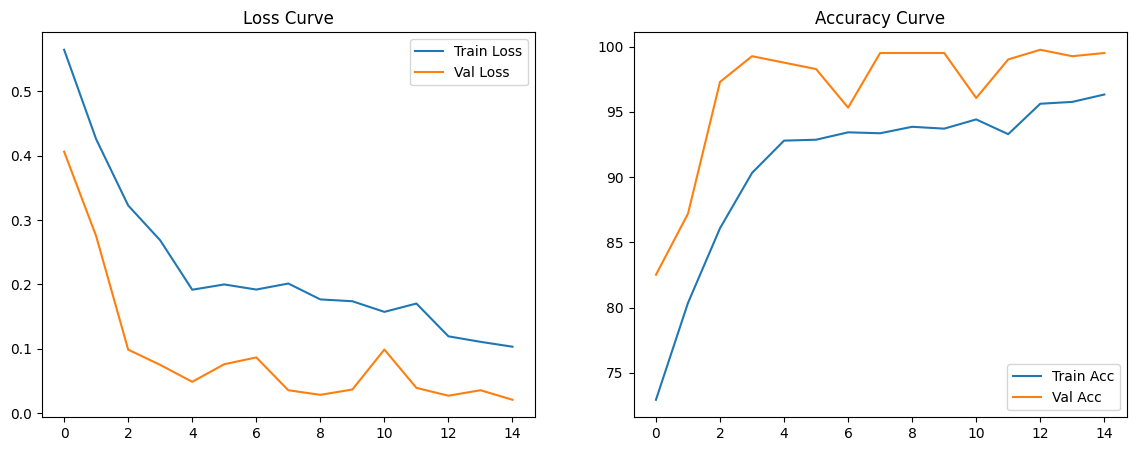

In [21]:
import matplotlib.pyplot as plt
# --- 8. PLOTTING ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(history['train_loss'], label='Train Loss')
ax[0].plot(history['val_loss'], label='Val Loss')
ax[0].set_title('Loss Curve')
ax[0].legend()

ax[1].plot(history['train_acc'], label='Train Acc')
ax[1].plot(history['val_acc'], label='Val Acc')
ax[1].set_title('Accuracy Curve')
ax[1].legend()
plt.show()

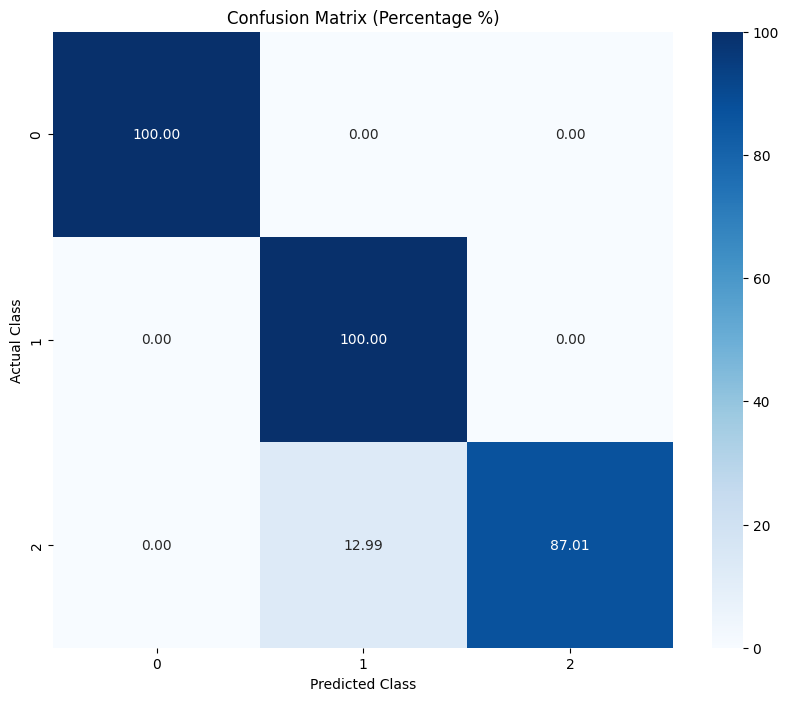

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Calculate the standard Confusion Matrix (Counts)
cm = confusion_matrix(all_targets, all_preds)

# 2. Convert to Percentages (Row-Wise Normalization)
# We divide each value by the sum of its row (Actual Class Total)
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# 3. Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm_pct, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)

# Add labels to make it clear
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix (Percentage %)')
plt.show()


Running t-SNE...
Extracting features from validation set...
Final Feature Shape: (406, 768)


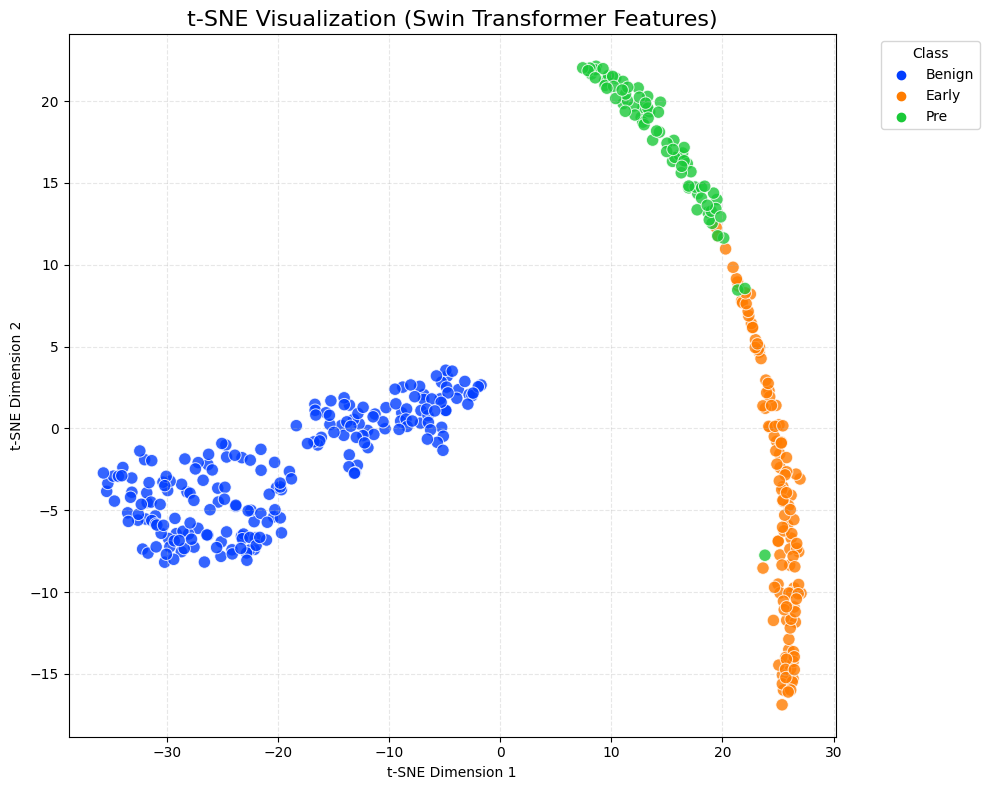

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import torch
import torch.nn as nn

# ==========================================
# 7. t-SNE VISUALIZATION (Fixed for Swin)
# ==========================================
print("\nRunning t-SNE...")

# 1. SETUP FEATURE EXTRACTOR
original_head = model.head 
model.head = nn.Identity() 

model.eval()
all_features = []
all_labels = []

print("Extracting features from validation set...")
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(DEVICE)
        
        # Swin Output Shape: [Batch, H, W, C] (e.g., [32, 7, 7, 768])
        features = model(inputs)
        
        # --- FIX: Apply Global Average Pooling ---
        # If output is 4D, we pool spatial dims to get [Batch, C]
        if features.ndim == 4:
            # Swin (timm) typically outputs (B, H, W, C), so we mean over dim 1 and 2
            # If your model outputs (B, C, H, W), change to dim=(2, 3)
            features = features.mean(dim=(1, 2)) 
        
        # Now shape is [Batch, 768] (Flat vector)
        all_features.append(features.cpu().numpy())
        all_labels.append(targets.numpy())

# Restore head
model.head = original_head

# 2. PREPARE DATA
X_feats = np.concatenate(all_features, axis=0)
y_true = np.concatenate(all_labels, axis=0)

# Double check shape (should be 2D now)
print(f"Final Feature Shape: {X_feats.shape}")
# If it's still not 2D for some reason, force flatten it:
if X_feats.ndim > 2:
    X_feats = X_feats.reshape(X_feats.shape[0], -1)

# 3. COMPUTE t-SNE
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(X_feats)

# 4. PLOT RESULTS
class_names = ['Benign', 'Early', 'Pre', 'Pro'] # Update to match your actual classes
y_true_names = [class_names[i] for i in y_true]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_embedded[:, 0], 
    y=X_embedded[:, 1], 
    hue=y_true_names, 
    palette='bright', 
    s=80, 
    alpha=0.8
)

plt.title('t-SNE Visualization (Swin Transformer Features)', fontsize=16)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [26]:
import torch
import os

# --- Define explicit path to Kaggle Output Directory ---
save_path = '/kaggle/working/swin_transformer_all_cml_cll_healthy_weights_f.pth'

# --- Save the weights ---
torch.save(model.state_dict(), save_path)

print(f"✅ Model weights saved successfully to: {save_path}")

# --- Verify the file exists ---
if os.path.exists(save_path):
    file_size = os.path.getsize(save_path) / (1024 * 1024)
    print(f"   File Size: {file_size:.2f} MB")
    
    print("\n📂 Content of /kaggle/working/:")
    print(os.listdir("/kaggle/working"))

✅ Model weights saved successfully to: /kaggle/working/swin_transformer_all_cml_cll_healthy_weights_f.pth
   File Size: 105.03 MB

📂 Content of /kaggle/working/:
['swin_4class_all_cml_cll_healthy_f.pth', '.virtual_documents', 'swin_transformer_all_cml_cll_healthy_weights_f.pth', 'swin_regularized_best.pth', 'swin_4class_all_cml_cll_healthy.pth']
